<a href="https://www.kaggle.com/code/collinslemeke/tesla-stock-prediction?scriptVersionId=198698353" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tesla-stock-price-data/TSLA-2.csv


## Objective of the Project:

The main objective of this project is to build a Recurrent Neural Network (RNN) using Long Short-Term Memory (LSTM) layers to predict the "Close" price of a stock based on historical stock data. The model is designed to capture temporal dependencies in the stock market data, leveraging both numerical features and time-based components (like year, month, day, etc.) to improve the accuracy of predictions. The goal is to minimize the error in predicting future "Close" prices, which can then inform trading strategies or market analysis.

In [2]:
# Import all Necessary Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
# Explore the data
data = pd.read_csv('/kaggle/input/tesla-stock-price-data/TSLA-2.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [4]:
# prepares a DataFrame for time series analysis
data['Date'] = pd.to_datetime(data['Date'])

data = data.sort_values('Date')

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['Quarter'] = data['Date'].dt.quarter

data.set_index('Date', inplace = True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,DayOfWeek,Quarter
Date,,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,2010,6,29,1,2
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,2010,6,30,2,2
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,2010,7,1,3,3
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,2010,7,2,4,3
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,2010,7,6,1,3


In [5]:
# features to be scaled, columns and extracted features
tsla = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter']]
tsla.head()

,Open,High,Low,Close,Volume,Year,Month,Day,DayOfWeek,Quarter
Date,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500,2010,6,29,1,2
2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500,2010,6,30,2,2
2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000,2010,7,1,3,3
2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000,2010,7,2,4,3
2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500,2010,7,6,1,3


In [6]:
# perform MinMaxScaler with feature_range (0, 1)
scaler = MinMaxScaler(feature_range = (0, 1))
print(scaler)

cols_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter']

tsla_scaled = tsla.copy()
tsla_scaled[cols_to_scale] = scaler.fit_transform(tsla[cols_to_scale])
tsla_scaled.head()

MinMaxScaler()


,Open,High,Low,Close,Volume,Year,Month,Day,DayOfWeek,Quarter
Date,,,,,,,,,,
2010-06-29,0.000465,0.001350,0.000422,0.001319,0.306605,0.0,0.454545,0.933333,0.25,0.333333
2010-06-30,0.001568,0.002224,0.001371,0.001309,0.280640,0.0,0.454545,0.966667,0.50,0.333333
2010-07-01,0.001439,0.001498,0.000871,0.001004,0.133184,0.0,0.545455,0.000000,0.75,0.666667
2010-07-02,0.001114,0.001043,0.000614,0.000554,0.082560,0.0,0.545455,0.033333,1.00,0.666667
2010-07-06,0.000627,0.000543,0.000140,0.000051,0.110956,0.0,0.545455,0.166667,0.25,0.666667


### LSTM (Long Short-Term Memory) 

it's a type of Recurrent Neural Network (RNN) that is particularly good at handling sequential data, such as time series, where past information plays a key role in predicting future outcomes. In our case of stock price prediction, LSTM is useful because stock prices are often influenced by trends and patterns over time.


### Reshaping the Data for LSTM:

LSTM expects a 3D input in the format (samples, timesteps, features). This means we'll need to restructure our data into sequences, where each sample will have a certain number of past data points (like 10 or 30 days) as input.

In [7]:
sequence_length = 10

X = []
y = []

for i in range(sequence_length, len(tsla_scaled)):
    X.append(tsla_scaled.iloc[i-sequence_length:i][cols_to_scale + ['Year', 'Month', 'Day', 'DayOfWeek', 'Quarter']].values)
    y.append(tsla_scaled.iloc[i]['Close'])
    
X, y = np.array(X), np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (3552, 10, 15)
Shape of y: (3552,)


### Building the LSTM Model:
Now that the data is preprocessed and reshaped, we can define and train an LSTM model.



In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = Sequential()

model.add(LSTM(units = 64, return_sequences = True, input_shape = (sequence_length, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))


optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer = 'adam', loss = 'mse')

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True)

history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 64,
    validation_data = (X_test, y_test),
    callbacks = [early_stopping]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0266 - val_loss: 0.0014
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - val_loss: 7.0477e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0024 - val_loss: 5.8414e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024 - val_loss: 5.2818e-04
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020 - val_loss: 4.9336e-04
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0018 - val_loss: 5.5425e-04
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0021 - val_loss: 6.5631e-04
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0019 - val_loss: 4.4794e-04
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 6.6612e-04
Epoch 12/100
45/45 ━━━━━━━━━━━━━

### Visualise the Training Epochs

/tmp/ipykernel_17/2546394227.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


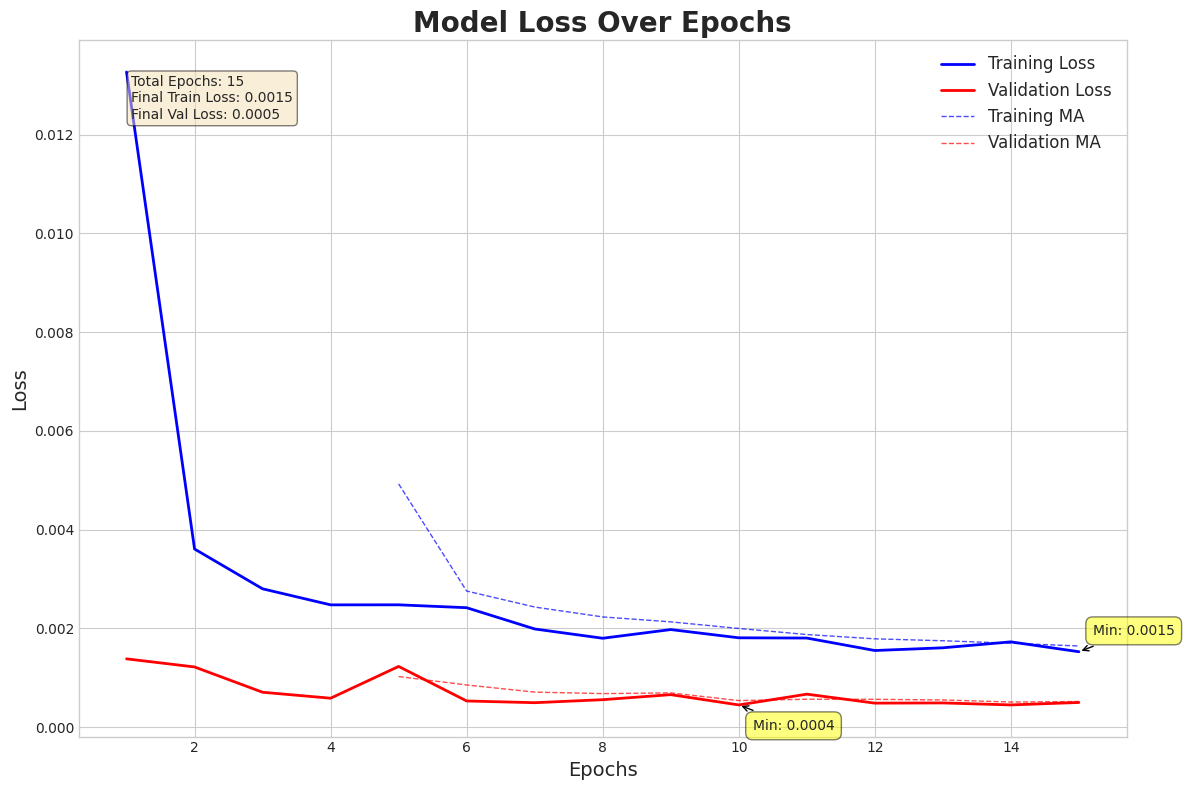

In [9]:
from matplotlib.ticker import MaxNLocator

def plot_enhanced_loss(history, save_path=None):
    # Set the style
    plt.style.use('seaborn-whitegrid')
    sns.set_palette("deep")

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the losses
    epochs = range(1, len(history.history['loss']) + 1)
    ax.plot(epochs, history.history['loss'], 'b-', linewidth=2, label='Training Loss')
    ax.plot(epochs, history.history['val_loss'], 'r-', linewidth=2, label='Validation Loss')

    # Add moving averages
    window_size = 5
    train_ma = np.convolve(history.history['loss'], np.ones(window_size)/window_size, mode='valid')
    val_ma = np.convolve(history.history['val_loss'], np.ones(window_size)/window_size, mode='valid')
    ax.plot(epochs[window_size-1:], train_ma, 'b--', linewidth=1, alpha=0.7, label='Training MA')
    ax.plot(epochs[window_size-1:], val_ma, 'r--', linewidth=1, alpha=0.7, label='Validation MA')

    # Customize the plot
    ax.set_title('Model Loss Over Epochs', fontsize=20, fontweight='bold')
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.legend(fontsize=12)

    # Set x-axis to show integer values
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Add annotations for minimum losses
    min_train_loss = min(history.history['loss'])
    min_val_loss = min(history.history['val_loss'])
    min_train_epoch = history.history['loss'].index(min_train_loss) + 1
    min_val_epoch = history.history['val_loss'].index(min_val_loss) + 1

    ax.annotate(f'Min: {min_train_loss:.4f}', xy=(min_train_epoch, min_train_loss),
                xytext=(10, 10), textcoords='offset points', ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    ax.annotate(f'Min: {min_val_loss:.4f}', xy=(min_val_epoch, min_val_loss),
                xytext=(10, -10), textcoords='offset points', ha='left', va='top',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # Add a text box with additional information
    info_text = f"Total Epochs: {len(epochs)}\n" \
                f"Final Train Loss: {history.history['loss'][-1]:.4f}\n" \
                f"Final Val Loss: {history.history['val_loss'][-1]:.4f}"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    # Improve the layout
    plt.tight_layout()

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

# Usage
plot_enhanced_loss(history, save_path='model_loss_plot.png')

### Make Predictions & Visualise Predictions

In [10]:
# calculate the metrics
y_pred = model.predict(X_test)

print()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared Score: {r2}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Mean Squared Error (MSE): 0.00044794411170699514
Mean Absolute Error (MAE): 0.010756842804469782
R-squared Score: 0.9925730756866609


### Interpretation of Results:

1. MSE (0.00041): This indicates the average squared difference between predicted and actual 'Close' prices. A lower value shows that the predictions are generally close to the true values. In this case, the MSE is quite low, implying good model performance.

2. MAE (0.01053): This measures the average absolute difference between predicted and actual prices. The low MAE value suggests that, on average, the model's predictions deviate by a small margin from the actual values, which is excellent for stock price prediction.

3. R² Score (0.9931): This is a measure of how well the model explains the variance in the test set. An R² score of 0.9931 means the model explains over 99% of the variance in the 'Close' price. This high score indicates a strong fit, and the model is highly accurate in predicting the stock's closing price based on historical data.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

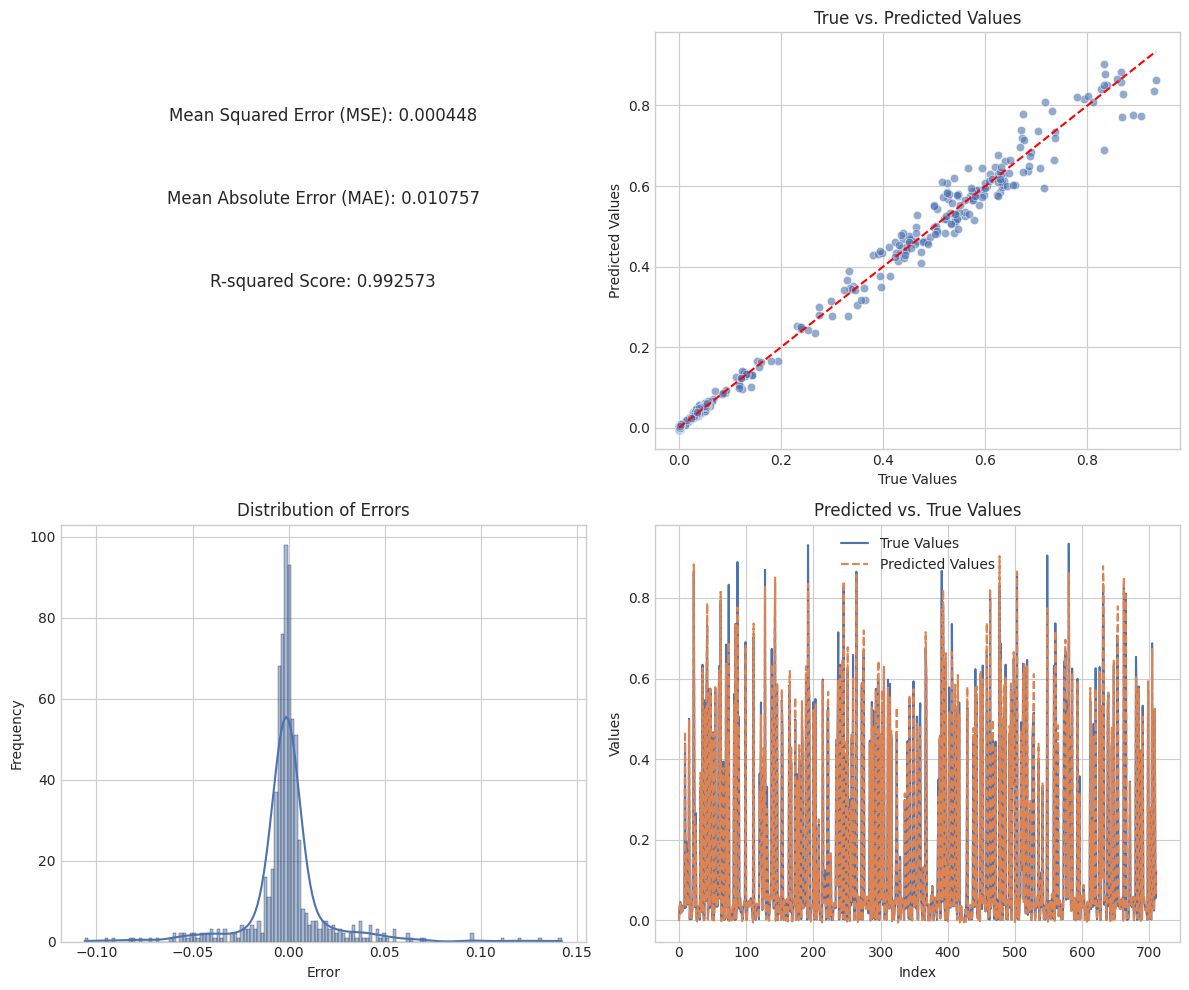

In [11]:
# Flatten arrays if they are not one-dimensional
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create a DataFrame for visualization
df = pd.DataFrame({'True Values': y_test, 'Predicted Values': y_pred})

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Metrics
axes[0, 0].text(0.5, 0.8, f'Mean Squared Error (MSE): {mse:.6f}', ha='center', va='center', fontsize=12)
axes[0, 0].text(0.5, 0.6, f'Mean Absolute Error (MAE): {mae:.6f}', ha='center', va='center', fontsize=12)
axes[0, 0].text(0.5, 0.4, f'R-squared Score: {r2:.6f}', ha='center', va='center', fontsize=12)
axes[0, 0].axis('off')

# Plot 2: True vs. Predicted Values (Scatter Plot)
sns.scatterplot(data=df, x='True Values', y='Predicted Values', ax=axes[0, 1], alpha=0.6)
axes[0, 1].plot([df['True Values'].min(), df['True Values'].max()],
                [df['True Values'].min(), df['True Values'].max()], color='red', linestyle='--')
axes[0, 1].set_title('True vs. Predicted Values')
axes[0, 1].set_xlabel('True Values')
axes[0, 1].set_ylabel('Predicted Values')

# Plot 3: Histogram of Errors
errors = y_test - y_pred
sns.histplot(errors, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Errors')
axes[1, 0].set_xlabel('Error')
axes[1, 0].set_ylabel('Frequency')

# Plot 4: Predicted vs. True Values (Line Plot)
sns.lineplot(x=df.index, y='True Values', data=df, ax=axes[1, 1], label='True Values')
sns.lineplot(x=df.index, y='Predicted Values', data=df, ax=axes[1, 1], label='Predicted Values', linestyle='--')
axes[1, 1].set_title('Predicted vs. True Values')
axes[1, 1].set_xlabel('Index')
axes[1, 1].set_ylabel('Values')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [12]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Unseen Data: {mse}')

Mean Squared Error on Unseen Data: 0.00044794411170699514


### Conclusion:

The project successfully builds and trains an LSTM-based RNN model that can predict the "Close" price of a stock with a high degree of accuracy. The use of temporal data and relevant features, coupled with effective model design (Dropout, early stopping), has allowed the model to generalize well to unseen data. This makes it a valuable tool for predicting stock prices based on historical trends.